In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

### Helper functions

In [7]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    """
    Simulates stock price paths using Geometric Brownian Motion (GBM).
    """
    dt = T / N
    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for i in range(1, N + 1):
        S[:, i] = S[:, i - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, M)
        )
    return S

def payoff_fun(S, K, style):
    if style == "put":
        return np.maximum(K - S, 0)
    else:
        return np.maximum(S - K, 0)

def create_shallow_NN(input_dim, no_hidden_units):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(no_hidden_units, activation="relu"))
    model.add(Dense(1, activation="linear"))
    return model

### Binomial Hedging

In [8]:


def build_binomial_tree_with_deltas(S0, K, T, r, sigma, N, exercise_dates, option_type="put"):
    """
    Builds a binomial tree for stock prices, option values, and deltas.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((N + 1, N + 1))
    option_tree = np.zeros((N + 1, N + 1))
    delta_tree = np.zeros((N, N))

    # Stock prices at maturity
    for i in range(N + 1):
        stock_tree[N, i] = S0 * (u ** (N - i)) * (d ** i)

    # Option values at maturity
    if option_type == "put":
        option_tree[N, :] = np.maximum(K - stock_tree[N, :], 0)
    else:
        option_tree[N, :] = np.maximum(stock_tree[N, :] - K, 0)

    # Backward induction for option values and deltas
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            stock_tree[i, j] = S0 * (u ** (i - j)) * (d ** j)
            continuation_value = np.exp(-r * dt) * (
                p * option_tree[i + 1, j] + (1 - p) * option_tree[i + 1, j + 1]
            )

            if option_type == "put":
                exercise_value = max(K - stock_tree[i, j], 0)
            else:
                exercise_value = max(stock_tree[i, j] - K, 0)

            if (i * dt) in exercise_dates:
                option_tree[i, j] = max(continuation_value, exercise_value)
            else:
                option_tree[i, j] = continuation_value

            delta_tree[i, j] = (
                option_tree[i + 1, j] - option_tree[i + 1, j + 1]
            ) / (stock_tree[i + 1, j] - stock_tree[i + 1, j + 1])

    return stock_tree, option_tree, delta_tree

def delta_hedging_experiment_bionmial_tree_gbm(
    S0, K, T, r, sigma, N, exercise_dates, option_type="put", num_simulations=10000
):
    """
    Performs a delta hedging experiment using GBM-simulated stock prices and binomial tree deltas.
    """
    # Build the binomial tree for option valuation and deltas
    _, _, delta_tree = build_binomial_tree_with_deltas(
        S0, K, T, r, sigma, N, exercise_dates, option_type
    )

    # Simulate GBM stock price paths
    stock_paths = stock_price_simulator(S0, r, sigma, T, N, num_simulations)

    total_cost = []
    pay_received = []

    dt = T / N

    for path in stock_paths:
        prev_delta = 0
        cost = 0

        for t in range(N):
            # Approximate delta by finding the closest stock price in the tree
            i = t
            stock_prices_at_t = S0 * (np.exp(sigma * np.sqrt(dt))) ** (
                i - np.arange(i + 1)
            ) * (np.exp(-sigma * np.sqrt(dt))) ** np.arange(i + 1)
            idx = (np.abs(stock_prices_at_t - path[t])).argmin()
            current_delta = delta_tree[t, idx]

            # Adjust portfolio
            delta_diff = current_delta - prev_delta
            cost -= delta_diff * path[t] * np.exp(-r * t * dt)
            prev_delta = current_delta

        # Option payoff at maturity
        if option_type == "put":
            payoff = max(K - path[-1], 0)
        else:
            payoff = max(path[-1] - K, 0)

        # Final adjustment for delta position
        cost += prev_delta * path[-1] * np.exp(-r * T)
        total_cost.append(cost)
        pay_received.append(-payoff * np.exp(-r * T))  # Discounted option payoff

    # Calculate P&L
    final_PnL = np.array(total_cost) + np.array(pay_received)
    return final_PnL

### RLLN Hedging

In [9]:
def RLNN_Algo_with_deltas(
    S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units
):
    """
    RLNN algorithm that also computes deltas at each time step.
    """
    N = no_mon
    dt = T / N
    deltas = np.zeros((sample_size, N + 1))

    stock_paths = stock_price_simulator(S0, r, vol, T, N, sample_size)
    option_price = np.zeros(stock_paths.shape)
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)

    for t in range(N - 1, -1, -1):
        # Prepare training data
        X = stock_paths[:, t].reshape(-1, 1)
        y = option_price[:, t + 1] * np.exp(-r * dt)

        # Normalize X
        normalizer = np.mean(X)
        X_normalized = X / normalizer

        # Convert X_normalized to tf.Variable
        X_normalized_tf = tf.Variable(X_normalized, dtype=tf.float32)

        # Train neural network
        model = create_shallow_NN(1, no_hidden_units)
        model.compile(loss="mean_squared_error", optimizer=Adam(0.001))
        early_stopping = EarlyStopping(
            monitor="loss", patience=5, restore_best_weights=True
        )
        model.fit(
            X_normalized,
            y,
            epochs=100,
            batch_size=128,
            callbacks=[early_stopping],
            verbose=0,
        )

        # Compute continuation value
        continuation_value = model.predict(X_normalized).flatten()

        # Compute immediate exercise value
        exercise_value = payoff_fun(X.flatten(), K, style)

        # Decide whether to continue or exercise
        option_price[:, t] = np.maximum(continuation_value, exercise_value)

        # Compute deltas (derivative of network output with respect to input)
        with tf.GradientTape() as tape:
            tape.watch(X_normalized_tf)
            y_pred = model(X_normalized_tf)
        grads = tape.gradient(y_pred, X_normalized_tf).numpy().flatten()
        # Adjust for normalization
        deltas[:, t] = grads / normalizer

    option_price_0 = np.mean(option_price[:, 0]) * np.exp(-r * dt)
    return option_price_0, deltas, stock_paths

def delta_hedging_experiment_RLNN(
    S0, K, T, r, sigma, N, option_type="put", num_simulations=1000, no_hidden_units=10
):
    """
    Performs a delta hedging experiment using RLNN-computed deltas.
    """
    dt = T / N
    # Run RLNN algorithm to get deltas and stock paths
    _, deltas, stock_paths = RLNN_Algo_with_deltas(
        S0, K, r, sigma, num_simulations, N, T, option_type, no_hidden_units
    )

    total_cost = []
    pay_received = []

    for i in range(num_simulations):
        path = stock_paths[i]
        prev_delta = 0
        cost = 0

        for t in range(N):
            current_delta = deltas[i, t]

            # Adjust portfolio
            delta_diff = current_delta - prev_delta
            cost -= delta_diff * path[t] * np.exp(-r * t * dt)
            prev_delta = current_delta

        # Option payoff at maturity
        payoff = payoff_fun(path[-1], K, option_type)

        # Final portfolio value
        final_portfolio = prev_delta * path[-1] * np.exp(-r * T)
        total_cost.append(cost + final_portfolio)
        pay_received.append(-payoff * np.exp(-r * T))  # Discounted option payoff

    # Calculate P&L
    final_PnL = np.array(total_cost) + np.array(pay_received)
    return final_PnL

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━

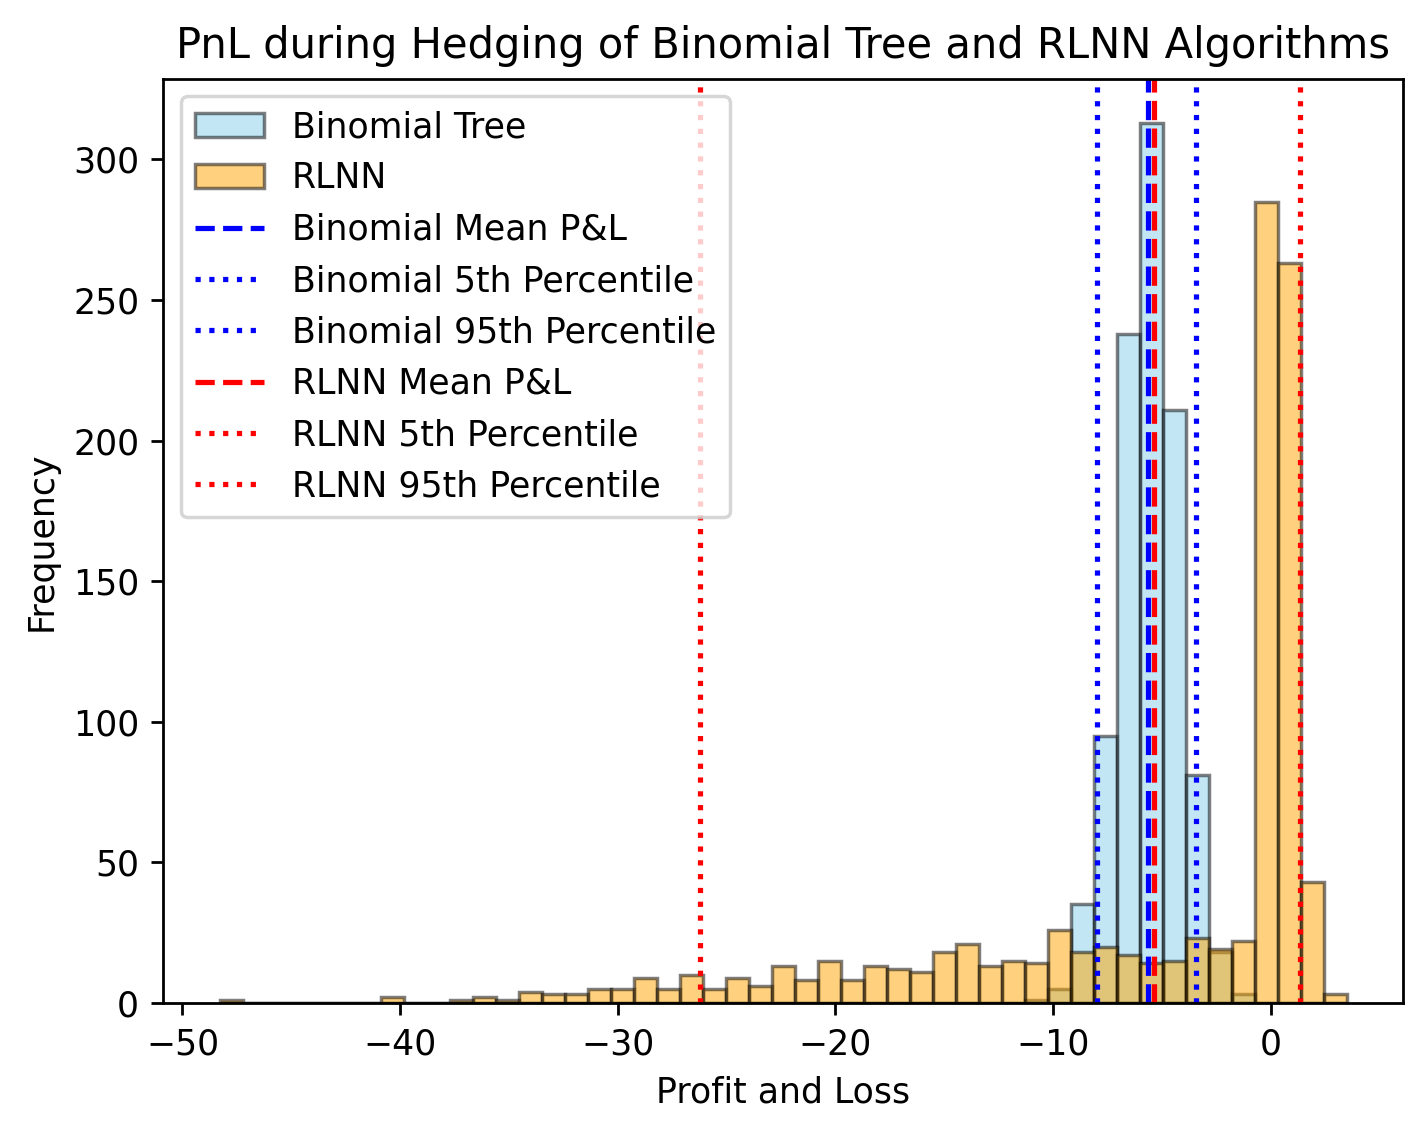

Binomial Tree - Mean P&L: -5.6131, 5th Percentile: -7.9706, 95th Percentile: -3.4402
RLNN - Mean P&L: -5.3414, 5th Percentile: -26.2213, 95th Percentile: 1.3634


In [10]:

# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 50
exercise_dates = [0.25, 0.5, 0.75, 1.0]
option_type = "put"
num_simulations = 1000  # Use the same number for both methods
no_hidden_units = 10

# Run the binomial tree hedging experiment
PnL_binomial = delta_hedging_experiment_bionmial_tree_gbm(
    S0, K, T, r, sigma, N, exercise_dates, option_type, num_simulations
)

# Run the RLNN hedging experiment
PnL_RLNN = delta_hedging_experiment_RLNN(
    S0, K, T, r, sigma, N, option_type, num_simulations, no_hidden_units
)

# Calculate statistics
mean_PnL_binomial = np.mean(PnL_binomial)
PnL_binomial_5 = np.percentile(PnL_binomial, 5)
PnL_binomial_95 = np.percentile(PnL_binomial, 95)

mean_PnL_RLNN = np.mean(PnL_RLNN)
PnL_RLNN_5 = np.percentile(PnL_RLNN, 5)
PnL_RLNN_95 = np.percentile(PnL_RLNN, 95)

# Plotting
fig, ax = plt.subplots(dpi=250)

bins = np.linspace(
    min(min(PnL_binomial), min(PnL_RLNN)),
    max(max(PnL_binomial), max(PnL_RLNN)),
    50,
)

ax.hist(
    PnL_binomial,
    bins=bins,
    alpha=0.5,
    label="Binomial Tree",
    edgecolor="black",
    color="skyblue",
)
ax.hist(
    PnL_RLNN,
    bins=bins,
    alpha=0.5,
    label="RLNN",
    edgecolor="black",
    color="orange",
)

# Plot mean and 95% CI for Binomial
ax.axvline(x=mean_PnL_binomial, color="blue", linestyle="--", label="Binomial Mean P&L")
ax.axvline(
    x=PnL_binomial_5, color="blue", linestyle=":", label="Binomial 5th Percentile"
)
ax.axvline(
    x=PnL_binomial_95, color="blue", linestyle=":", label="Binomial 95th Percentile"
)

# Plot mean and 95% CI for RLNN
ax.axvline(x=mean_PnL_RLNN, color="red", linestyle="--", label="RLNN Mean P&L")
ax.axvline(x=PnL_RLNN_5, color="red", linestyle=":", label="RLNN 5th Percentile")
ax.axvline(x=PnL_RLNN_95, color="red", linestyle=":", label="RLNN 95th Percentile")

ax.set_xlabel("Profit and Loss")
ax.set_ylabel("Frequency")
ax.legend()
plt.title("PnL during Hedging of Binomial Tree and RLNN Algorithms")
plt.show()

print(
    f"Binomial Tree - Mean P&L: {mean_PnL_binomial:.4f}, "
    f"5th Percentile: {PnL_binomial_5:.4f}, 95th Percentile: {PnL_binomial_95:.4f}"
)
print(
    f"RLNN - Mean P&L: {mean_PnL_RLNN:.4f}, "
    f"5th Percentile: {PnL_RLNN_5:.4f}, 95th Percentile: {PnL_RLNN_95:.4f}"
)
